In [1]:
import numpy as np
import pyemma
import msmtools.estimation as est
import msmtools
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyemma.plots as mplt
import h5py
import MSMRD.trajectories.trajectoryTools as trajectoryTools
from MSMRD.discretization import partitionSphere, plotPartitionedSphere
from MSMRD.visualization import createDensityData
import pickle
#%load_ext Cython
plt.style.use('paperPlot')
%matplotlib inline

In [2]:
matplotlib.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rc('text', usetex='True')
plt.rc('font', family='serif')

In [ ]:
# Testing correct state output mini script (use along with testSpherePrtitionPlot NB)
# Consistent with test
numPartitions = 1
boxSize = 6
innerMSMrad = 2.5
minima = np.array([[-0.9,0.7,0.3] , [-0.1,0.9,0.7],  [0.8,0.8,-0.8],  \
                  [-1.0,-0.3,-0.4], [0.0,0.0,0.0],   [0.9,-0.1,-0.9], \
                  [-0.7,-1.0,-0.3], [0.0,-0.9,0.1],  [0.8,-0.2,0.8]])
regionsPerCollar, phis, thetas = partitionSphere(numPartitions)
discretizer = trajectoryTools.trajDiscretization3DCython(minima, boxSize, innerMSMrad)
discretizer.getSpherePartition(regionsPerCollar, phis, thetas)
coord = np.array([3.4,-2,-2]) # norm larger than innerMSMrad (boxSize/2)
sphereState = discretizer.getStatePy(coord,-1) - (len(minima) - 1)

# Call function to plot state and coordinate in spherical partition
print sphereState
plotPartitionedSphere(numPartitions = numPartitions, plotState=sphereState, coord=coord)
#plt.savefig('../Report/figs/3Dsphere_partition.pdf')

In [11]:
%%time
numfiles = 120
# Load partitions, boxsize and minimas
numPartitions = 100
boxSize = 5.
innerMSMrad = 2.5
regionsPerCollar, phis, thetas = partitionSphere(numPartitions)
minima = np.array([[-0.9,0.7,0.3] , [-0.1,0.9,0.7],  [0.8,0.8,-0.8],  \
                  [-1.0,-0.3,-0.4], [0.0,0.0,0.0],   [0.9,-0.1,-0.9], \
                  [-0.7,-1.0,-0.3], [0.0,-0.9,0.1],  [0.8,-0.2,0.8]])

# Extract trajectories from file using asym2Dtraj class
# fname = '../data/asym3D/3DasymTrajs_pBox5_sf2_R4_RT1e7_dt001_si10_' # old data with bug in potential
# fname = '../data/asym3D/3DasymTrajs_pbox5_RT1e7_sf2.0_dt0.001_si10_run_'
#fname = '../data/asym3D/box6/3DasymTrajs_pbox5_RT1e7_sf2.0_dt0.0001_si10_run_'
fname = '/group/ag_cmb/scratch/dibakma/MSMRD/asym3D/box6/3DasymTrajs_pbox6_RT1e7_sf2.0_dt0.0001_si10_run_'
dimension = 3
discretizer = trajectoryTools.trajDiscretization3DCython(minima, boxSize, innerMSMrad)
discretizer.getSpherePartition(regionsPerCollar, phis, thetas)
trajs = []
dTrajs = []
#fullDTrajs = []
truncTrajs = []
dTruncTrajs = []
truncatedTrajs = []
dTruncatedTrajs = []
i = 0
samplingInterval = 10 # in the original computation
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], samplingInterval):
        print 'timestep not constant'
    traj = data[:,1:dimension+1]
    #fullDTrajs.append(discretizer.getdTrajs([traj]))
    dTrajs += discretizer.getdTrajs([traj])
    lastTruncTrajs = discretizer.getTruncatedTraj(traj, prepend=True) # Use True for code, false for traj plotting?
    truncatedTrajs.append(lastTruncTrajs)
    truncTrajs += lastTruncTrajs
    lastDTruncTrajs = discretizer.getdTrajs(lastTruncTrajs)
    dTruncTrajs += lastDTruncTrajs
    dTruncatedTrajs.append(lastDTruncTrajs)
    i+=1
    if i % 10 == 0:
        print str(i/float(numfiles) * 100)+'% done'
    # delete memory to avoid overhead
    del data
    del traj
    #trajs.append(traj) # Need to pass to create density data for visit visualization

8.33333333333% done
16.6666666667% done
25.0% done
33.3333333333% done
41.6666666667% done
50.0% done
58.3333333333% done
66.6666666667% done
75.0% done
83.3333333333% done
91.6666666667% done
100.0% done
CPU times: user 26min 9s, sys: 6.36 s, total: 26min 15s
Wall time: 26min 23s


In [ ]:
# visualize trunc trajs
def plotTrajs(trajs,numTrajs):
    fig = plt.figure(figsize=[10,10])
    ax = fig.gca(projection='3d') 
    i=0
    print(len(trajs))
    for traj in trajs:
        trajx = []
        trajy = []
        trajz = []
        for i in range(len(traj)):
            trajx.append(traj[i][0])
            trajy.append(traj[i][1])
            trajz.append(traj[i][2])
        #ax.plot(trajx,trajy,trajz,'.')
        ax.plot(trajx,trajy,trajz,'b-', lw=0.0002)
        i += 1
        if i > numTrajs:
            break
            
plotTrajs(truncTrajs,100000)
for i in range(len(minima)):
    ax.text(minima[i,0], minima[i,1], minima[i,2], str(i), color='black', size=25)

In [12]:
# Get exit/entry lookup tables
%time
# CALL WITH dTruncTrajs or dTrajs, see function in trajectoryTools.pyx
entryTrajsStart, entryTrajsEnd, entryTimes = discretizer.getLookupTableEntry(dTruncTrajs, truncTrajs)
exitPositions, exitTimes = discretizer.getLookupTableExit(dTruncTrajs, truncTrajs)
transitionTrajs = discretizer.getTransitionTrajs(dTruncTrajs)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


In [13]:
#find exit trajectories
%time
exitTrajs = []
for i in range(9):
    exitTrajs += (transitionTrajs[i][9])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


In [14]:
def implied_timescales_resampling(lag, nsamples):
    samples = []
    trajectories = numfiles
    impliedTimescales = []
    for i in range(nsamples):
        sampleIndices = np.random.choice(trajectories, size=trajectories, replace=True)
        sample = [dTrajs[j] for j in sampleIndices]
        sampleTrTrajs = []
        for j in range(trajectories):
            sampleTrTrajs += dTruncatedTrajs[sampleIndices[j]]
        transitionTrajSample = discretizer.getTransitionTrajs(sampleTrTrajs)
        exitTrajsSample = []
        for j in range(9):
            exitTrajsSample += transitionTrajSample[j][9]
        fullCount = est.count_matrix(sample, lag, sliding=True, sparse_return=False)
        exitCounts = est.count_matrix(exitTrajsSample, lag, sliding=True, sparse_return=False)
        finalCountMatrix = 1. * np.asarray(fullCount)
        for j in range(9):
            finalCountMatrix[j,j] -= exitCounts[j,j]
        if np.any(finalCountMatrix < 0):
            print 'negative entry in final count Matrix'
            return fullCount, exitCounts
        if np.any(np.sum(finalCountMatrix[:9,:9], axis=1) == 0):
            print 'skipped sample due to sum being zero before estimation'
            continue
        tmatrix = np.asarray(est.transition_matrix(finalCountMatrix[:9,:9], reversible=False))
        if np.any(tmatrix < 0):
            print 'negative entry in tmatrix'
        internalTmatrix = np.copy(tmatrix).astype('float64')
        if np.any(np.sum(internalTmatrix, axis=1) == 0):
            print 'skipped sample due to sum being zero'
            continue
        if np.any(internalTmatrix < 0):
            print 'negative entry in internal tmatrix'
        #for j in range(len(internalTmatrix)):
        #    internalTmatrix[j,:] /= np.sum(internalTmatrix[j,:])
        try:
            assert np.allclose(np.sum(internalTmatrix, axis=1), 1)
        except:
            print 'assertion failed' + str(i)
            return internalTmatrix
        if not est.is_connected(internalTmatrix):
            print 'skipped sample as is not connected'
            continue
        try:
            msm = pyemma.msm.markov_model(internalTmatrix, dt_model=str(lag) + ' step')
        except:
            print 'not a T matrix'
            print np.any(internalTmatrix < 0)
            return internalTmatrix
        impliedTimescales.append(msm.timescales())
    return np.array(impliedTimescales)

In [28]:
#estimate error of implied timescales through resamlping
lags = []
timescales = []
errors = []
nsamples = []
for lag in range(1, 100, 10):
    print lag
    its = implied_timescales_resampling(lag, 100)
    timescales.append(np.mean(its, axis=0))
    errors.append(np.std(its, axis=0))
    lags.append(lag)
    nsamples.append(len(its))

1
11
21
31
41
51
61
71
81
91


In [39]:
itsArray = [np.array(lags), np.array(timescales), np.array(errors)]
pickle.dump(itsArray, open('/group/ag_cmb/scratch/dibakma/MSMRD/models/asym3D/impliedTimescales.p', 'wa'))

In [5]:
lags, timescales, errors = pickle.load(open('/group/ag_cmb/scratch/dibakma/MSMRD/models/asym3D/impliedTimescales.p', 'r'))

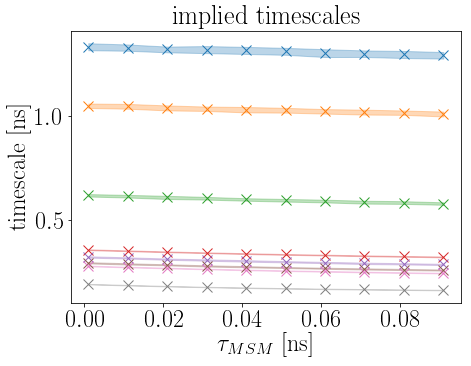

In [11]:
# Do the actual plot with proper timescaling
plt.style.use('paperPlot')
matplotlib.rcParams.update({'ytick.labelsize':24, 'xtick.labelsize':24, 'axes.labelsize':24, 'axes.titlesize':26})
plt.rcParams['figure.figsize'] = (7, 5)
scale = 0.001
for i in range(8):
    #plt.plot(np.array(lagtimes)*scale, scale*baysianTimescales[:,i], c='C'+str(i%9))
    plt.plot(np.array(lags)*scale, scale*np.array(timescales)[:,i], 'x', c='C'+str(i%9))
    plt.fill_between(np.array(lags)*scale, (np.array(timescales)[:,i]+np.array(errors)[:,i])*scale, (np.array(timescales)[:,i]-np.array(errors)[:,i])*scale, alpha=0.3, color='C'+str(i%9))
plt.xlabel('$\\tau_{MSM}$ [ns]')
plt.ylabel('timescale [ns]')
plt.title('implied timescales')
#plt.yscale('log')
plt.savefig('../../Paper/figs/asym3D/impliedTimescales_resamplingError_units.pdf', bbox_inches='tight')

In [ ]:
# compute count matrix for full trajectories and exit trajectories
# timestep 50!
fullCount = est.count_matrix(dTrajs, 50)
exitCounts = est.count_matrix(exitTrajs, 50)

In [ ]:
# subtract exit counts
finalCountMatrix = 1. * fullCount[:9,:9]
for i in range(9):
    finalCountMatrix[i,i] -= exitCounts[i,i]

In [ ]:
# extract inner transition matrix and renormalize
tmatrix = est.transition_matrix(finalCountMatrix, reversible=False).todense()
treduced = np.copy(tmatrix[:9,:9])
for i in range(9):
    treduced[i,:] /= np.sum(treduced[i,:])
for i in range(9):
    print (treduced[i,i])

In [ ]:
# Calculate exit probabilities for each of the inner states
exitProbs = np.zeros(len(minima))
for i in range(len(minima)):
    outgoingTrajs = 0
    for j in range(10):
        outgoingTrajs += len(transitionTrajs[i][j])   
    exitProbs[i] = len(transitionTrajs[i][len(minima)])/float(outgoingTrajs)
print exitProbs

In [ ]:
# Plot exit positions
for i in range(9):
    plt.scatter(np.array(exitPositions[i])[:,0], np.array(exitPositions[i])[:,1])

In [ ]:
# Partition MSM entry trajectories into discrete regions in the sphere 
numPartitions=240
spherePartitionsForLookUp = 1*numPartitions
regionsPerCollar2, phis2, thetas2 = partitionSphere(spherePartitionsForLookUp)
thetas_coord = np.arctan2(entryTrajsStart[:,1], entryTrajsStart[:,0])
thetas_coord[thetas_coord<0] = thetas_coord[thetas_coord<0] + 2*np.pi
r = np.linalg.norm(entryTrajsStart[:], axis=1)
phis_coords = np.arccos(entryTrajsStart[:,2]/r)
sortedEntryTrajsStart = []
sortedEntryTrajsEnd = []
sortedEntryTimes = []
for i in range(len(regionsPerCollar2)):
    phiIncrement = np.pi/len(regionsPerCollar2)
    idcs_phi = np.where(np.logical_and(phis_coords>i*phiIncrement, phis_coords<= (i+1)*phiIncrement))[0]
    for j in range(regionsPerCollar2[i]):
        thetaIncrement = 2*np.pi/regionsPerCollar2[i]
        idcs_theta = np.where(np.logical_and(thetas_coord>j*thetaIncrement, thetas_coord<= (j+1)*thetaIncrement))[0]
        idcs = np.intersect1d(idcs_phi,idcs_theta)
        sortedEntryTrajsStart.append(entryTrajsStart[idcs])
        sortedEntryTimes.append(entryTimes[idcs])
        sortedEnds = []
        for j in idcs:
            sortedEnds.append(entryTrajsEnd[j])
        sortedEntryTrajsEnd.append(sortedEnds)

In [ ]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class truncTrajsModel3D(object):    
    def __init__(self, entryTrajsStart, entryTrajsEnd, entryTimes, exitTrajs, exitTimes, exitProbs, MSMtime, tmatrix, numPartitions):
        self.entryTrajsStart = entryTrajsStart
        self.entryTrajsEnd = entryTrajsEnd
        self.entryTimes = entryTimes
        self.exitTrajs = exitTrajs
        self.exitTimes = exitTimes
        self.exitProbs = exitProbs
        self.tmatrix = tmatrix
        self.MSMtimestep = MSMtime
        self.numPartitions = numPartitions

In [ ]:
model = truncTrajsModel3D(sortedEntryTrajsStart, sortedEntryTrajsEnd, sortedEntryTimes, exitPositions, exitTimes, exitProbs, 0.05, treduced, numPartitions)

In [ ]:
import pickle
pickle.dump(model, open('/group/ag_cmb/scratch/dibakma/MSMRD/models/asym3D/periodicModel_lag0.05_R2.5_121files_240partitions.p', 'wa'))